## Setup autoreload, warnings and helper functions

In [19]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set the visibility of cuda devices (in case your system contains more than one)

In [20]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


## Imports

In [21]:
%matplotlib inline
from config import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
import pickle
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import SimpleDataset

from tools import apply_pipeline, crop_step, curry, apply_pipeline_cocodataset, get_save_step
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, create_database, identify, identify_single, encode_dataset
from reidentification.visualisation import visualise_match
from simple_database import DBDatabase

## Create a configuration file.
You can change the default parameters in config.py

In [22]:
cfg = config()

/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
/ekaterina/env/norppa/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Path to the dataset

In [23]:
cfg["dataset_dir"] = "/ekaterina/work/data/dataset-0520/segmented_pattern_resized/query"
cfg["dataset_db_dir"] = "/ekaterina/work/data/dataset-0520/segmented_pattern_resized/database"

dataset_dir = Path(cfg["dataset_dir"])
dataset_db_dir = Path(cfg["dataset_db_dir"])

print(f'SealID dataset is ready')

SealID dataset is ready


## Create dataset variables

In [24]:
pattern_query_dataset = SimpleDataset(dataset_dir)

print(len(pattern_query_dataset))

img_data = pattern_query_dataset[3]
print(img_data)

1650
(<PIL.Image.Image image mode=RGB size=254x100 at 0x7F0D51878150>, {'class_id': 'phs026', 'file': '/ekaterina/work/data/dataset-0520/segmented_pattern_resized/query/phs026/IM000306.JPG.result.png', 'dataset_dir': PosixPath('/ekaterina/work/data/dataset-0520/segmented_pattern_resized/query')})


## Show an image from the dataset

# Input image

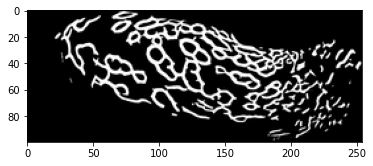

In [25]:
img, label = img_data

print_heading("Input image")
plt.imshow(img)
plt.show()

## Encode dataset

In [26]:
encoded_dataset = encode_dataset(pattern_query_dataset, cfg)
print(len(encoded_dataset))
print("Encoded dataset")

  0%|                                                  | 0/1650 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|███████████████████████████████████████| 1650/1650 [33:21<00:00,  1.21s/it]


Calculating PCA
Getting encoding parameters...
Encoding...
1650
Encoded dataset


In [27]:

with open("temp/files/encoded_sealid.pickle", 'wb') as f_file:
    pickle.dump(encoded_dataset, f_file)

In [28]:

with open("temp/files/encoded_sealid.pickle", 'rb') as f_file:
    encoded_dataset = pickle.load(f_file)

## Load database for testing
This example uses a very simple database implemented as a Python class. 

In [29]:
# db_database = DBDatabase("norppa", cfg)

db_database = SimpleDataset(dataset_db_dir)
db_database = encode_dataset(db_database, cfg)

# print(len(db_database.get_fisher_vectors()))
print(len(db_database))
print("Created a test database")

  0%|                                                   | 0/430 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|█████████████████████████████████████████| 430/430 [08:37<00:00,  1.20s/it]


Calculating PCA
Getting encoding parameters...
Encoding...
430
Created a test database


## Perform re-identification

In [30]:
identification_result = identify(encoded_dataset, db_database, cfg)

test features (1650, 179200)
db features (430, 179200)


100%|████████████████████████████████████| 1650/1650 [00:00<00:00, 52825.79it/s]


## Calculate the accuracy

In [31]:
db_labels = np.array([[x['db_label']['class_id'] for x in y[0]] for y in identification_result])
print(db_labels)
q_labels = np.array(pattern_query_dataset.get_labels())

print(len(q_labels))


topk = 5

hits = (db_labels.T == q_labels).T
print([sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(q_labels)
        for j in range(topk)])

[['phs230' 'phs026' 'phs130' 'phs213' 'phs174']
 ['phs130' 'phs026' 'phs101' 'phs026' 'phs080']
 ['phs026' 'phs026' 'phs130' 'phs100' 'phs130']
 ...
 ['phs219' 'phs219' 'phs219' 'phs109' 'phs223']
 ['phs219' 'phs219' 'phs223' 'phs109' 'phs160']
 ['phs223' 'phs096' 'phs147' 'phs149' 'phs096']]
1650
[0.7727272727272727, 0.8036363636363636, 0.8242424242424242, 0.8369696969696969, 0.850909090909091]


## Visualise re-identification results

In [ ]:
visualise_match(identification_result[0])
print()

## Apply full pipeline to another query image

In [ ]:
full_pipeline = [
            tonemap_step, 
            segment_step, crop_step,
            extract_pattern_step,
            curry(encode_pipeline, cfg=cfg),
            curry(identify_single, database=simple_db, cfg=cfg),
            visualise_match
            ]

apply_pipeline(*query_dataset[0], full_pipeline)
print()